In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lastversion/metadata_COVID.csv
/kaggle/input/lastversion/metadata_NORMAL.csv
/kaggle/input/lastversion/metadata_PNEUMONIA.csv
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_15_0103_02.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0195_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0012_02.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0849_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_08_0092_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_13_0031_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0034_01.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0242_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0197_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0379_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0602_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous

In [2]:
!pip install pydicom


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import pydicom as dicom
from PIL import Image
import PIL
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, Lambda, Resize
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
class SmokerDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None, labeled=True):
        self.transforms = transforms
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image
        file_name = str(self.df['filename'].iloc[idx])
        file_path = f"/kaggle/input/lastversion/clean_data/clean_data/{file_name}"
        
        if file_name.endswith(".dcm"):
            dicom_img = dicom.dcmread(file_path)
            new_img = dicom_img.pixel_array
            scaled_image = (np.maximum(new_img, 0) / new_img.max()) * 255.0
            scaled_image = np.uint8(scaled_image)
            img = Image.fromarray(scaled_image)
        else:
            img = Image.open(file_path).convert("RGB")  

        if self.transforms:
            img = self.transforms(img)

        label = dict_label.get(self.df['smoke'].iloc[idx], -1) 

        return img, label


In [5]:
dict_label={'Yes':1, 'No':0}

In [6]:
df_normal = pd.read_csv('/kaggle/input/lastversion/metadata_NORMAL.csv')
df_covid = pd.read_csv('/kaggle/input/lastversion/metadata_COVID.csv') 
df_pneumon = pd.read_csv('/kaggle/input/lastversion/metadata_PNEUMONIA.csv') 

In [7]:
df = pd.DataFrame(pd.concat([df_covid, df_normal, df_pneumon], axis=0))
df = df.reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4809 non-null   object 
 1   filename      4809 non-null   object 
 2   patient_id    4809 non-null   int64  
 3   hospital      4809 non-null   object 
 4   hospital_eng  4809 non-null   object 
 5   hospital_id   4809 non-null   int64  
 6   sex           2658 non-null   object 
 7   age           2723 non-null   float64
 8   smoke         823 non-null    object 
 9   smoke_number  160 non-null    float64
 10  class         4809 non-null   object 
 11  class_id      4809 non-null   int64  
 12  quality       4809 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 488.5+ KB


In [9]:
import os
import pandas as pd
path = '/kaggle/input/lastversion/clean_data/clean_data/'
files_in_directory = set(os.listdir(path))
df = df[df['filename'].isin(files_in_directory)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4230 non-null   object 
 1   filename      4230 non-null   object 
 2   patient_id    4230 non-null   int64  
 3   hospital      4230 non-null   object 
 4   hospital_eng  4230 non-null   object 
 5   hospital_id   4230 non-null   int64  
 6   sex           2413 non-null   object 
 7   age           2477 non-null   float64
 8   smoke         820 non-null    object 
 9   smoke_number  159 non-null    float64
 10  class         4230 non-null   object 
 11  class_id      4230 non-null   int64  
 12  quality       4230 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 429.7+ KB


In [10]:
# Create labeled and unlabeled datasets
labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True)
labeled_train, labeled_test = train_test_split(labeled_df, test_size=0.2, random_state=42)
labeled_train, labeled_val = train_test_split(labeled_train, test_size=0.1, random_state=42)

labeled_train = labeled_train.reset_index(drop=True)
labeled_val = labeled_val.reset_index(drop=True)
labeled_test = labeled_test.reset_index(drop=True)

unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True)

print("Labeled Train Dataset Info:")
print(labeled_train.info())
print("\nLabeled Validation Dataset Info:")
print(labeled_val.info())
print("\nUnlabeled Dataset Info:")
print(unlabeled_df.info())

Labeled Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        590 non-null    object 
 1   filename      590 non-null    object 
 2   patient_id    590 non-null    int64  
 3   hospital      590 non-null    object 
 4   hospital_eng  590 non-null    object 
 5   hospital_id   590 non-null    int64  
 6   sex           580 non-null    object 
 7   age           588 non-null    float64
 8   smoke         590 non-null    object 
 9   smoke_number  107 non-null    float64
 10  class         590 non-null    object 
 11  class_id      590 non-null    int64  
 12  quality       590 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 60.0+ KB
None

Labeled Validation Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 13 columns):
 #   Column      

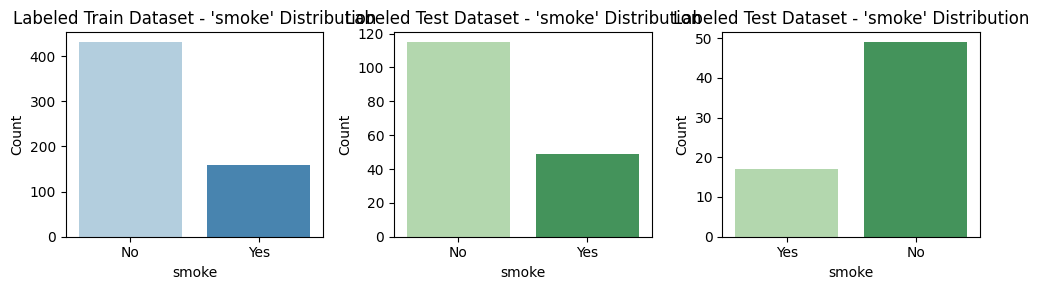

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
sns.countplot(data=labeled_train, x='smoke', palette='Blues')
plt.title("Labeled Train Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=labeled_test, x='smoke', palette='Greens')
plt.title("Labeled Test Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')


plt.subplot(1, 3, 3)
sns.countplot(data=labeled_val, x='smoke', palette='Greens')
plt.title("Labeled Test Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct_preds, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total
    return train_loss, train_accuracy


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct_preds, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_accuracy = correct_preds / total
    return val_loss, val_accuracy


def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels


def plot_learning_curves(train_losses, train_accuracies, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


import pandas as pd

def train_and_evaluate_cross_validation(models_dict, train_dataset, val_dataset, test_dataset, device, criterion, 
                                         learning_rates, batch_sizes, num_epochs=10):
    results = []

    for model_name, model in models_dict.items():
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTraining {model_name} with LR={lr}, Batch Size={batch_size}")
                model = model.to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

                train_losses, train_accuracies = [], []

                for epoch in range(num_epochs):
                    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
                    train_losses.append(train_loss)
                    train_accuracies.append(train_accuracy)
                    scheduler.step()

                    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

                val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
                all_preds, all_labels = test_model(model, test_loader, device)
                report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"], output_dict=True)
                cm = confusion_matrix(all_labels, all_preds)
                results.append({
                    'Model': model_name,
                    'Learning Rate': lr,
                    'Batch Size': batch_size,
                    'Final Train Loss': train_losses[-1],
                    'Final Train Accuracy': train_accuracies[-1],
                    'Validation Loss': val_loss,
                    'Validation Accuracy': val_accuracy,
                    'Test Accuracy': report['accuracy']
                })
                print(report)
                ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
                plt.title(f"Confusion Matrix: {model_name}, LR={lr}, Batch Size={batch_size}")
                plt.show()

                plot_learning_curves(train_losses, train_accuracies, num_epochs)

    results_df = pd.DataFrame(results)
    print("\nSummary of Cross-Validation Results:")
    print(results_df)

    return results_df


def create_models():
    models_dict = {
        'ResNet50': models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
        'MobileNetV3': models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1),
        'EfficientNetB0': models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    }
    for name, model in models_dict.items():
        # Modify the final layer to match the number of classes
        if name == 'ResNet50':
            model.fc = nn.Linear(model.fc.in_features, 2)
        else:
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    return models_dict

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s] 
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 137MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightm


Training ResNet50 with LR=0.0001, Batch Size=64
Epoch 1/20 - Train Loss: 0.1113, Train Acc: 0.5356
Epoch 2/20 - Train Loss: 0.0641, Train Acc: 0.7559
Epoch 3/20 - Train Loss: 0.0410, Train Acc: 0.7780
Epoch 4/20 - Train Loss: 0.0350, Train Acc: 0.8356
Epoch 5/20 - Train Loss: 0.0220, Train Acc: 0.8559
Epoch 6/20 - Train Loss: 0.0142, Train Acc: 0.8797
Epoch 7/20 - Train Loss: 0.0117, Train Acc: 0.8847
Epoch 8/20 - Train Loss: 0.0047, Train Acc: 0.9254
Epoch 9/20 - Train Loss: 0.0055, Train Acc: 0.9220
Epoch 10/20 - Train Loss: 0.0025, Train Acc: 0.9508
Epoch 11/20 - Train Loss: 0.0030, Train Acc: 0.9525
Epoch 12/20 - Train Loss: 0.0019, Train Acc: 0.9542
Epoch 13/20 - Train Loss: 0.0025, Train Acc: 0.9373
Epoch 14/20 - Train Loss: 0.0012, Train Acc: 0.9695
Epoch 15/20 - Train Loss: 0.0011, Train Acc: 0.9712
Epoch 16/20 - Train Loss: 0.0006, Train Acc: 0.9831
Epoch 17/20 - Train Loss: 0.0024, Train Acc: 0.9763
Epoch 18/20 - Train Loss: 0.0006, Train Acc: 0.9847
Epoch 19/20 - Train Loss

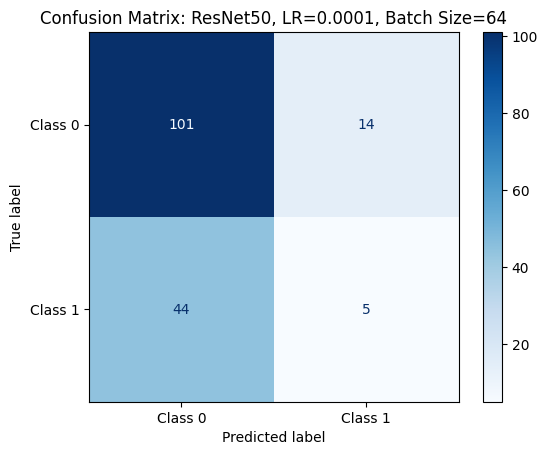

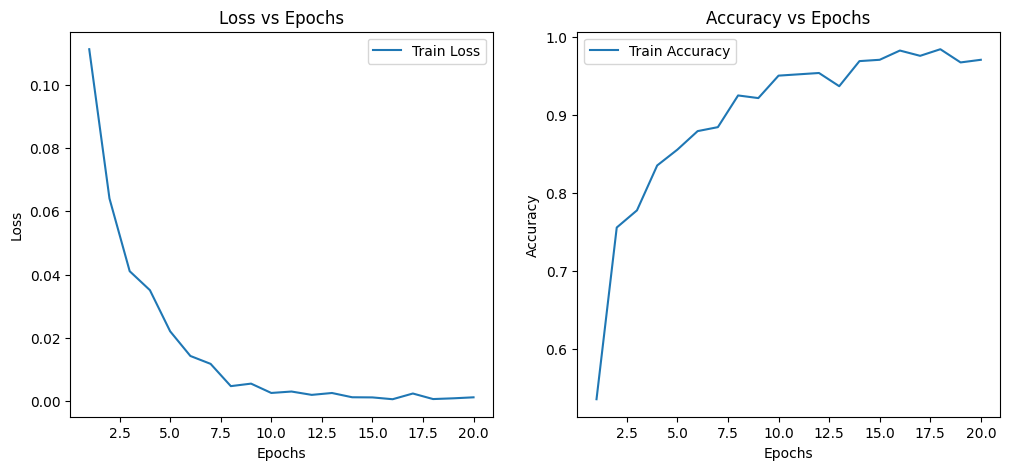


Training MobileNetV3 with LR=0.0001, Batch Size=64
Epoch 1/20 - Train Loss: 0.0780, Train Acc: 0.6966
Epoch 2/20 - Train Loss: 0.0607, Train Acc: 0.7390
Epoch 3/20 - Train Loss: 0.0490, Train Acc: 0.7508
Epoch 4/20 - Train Loss: 0.0387, Train Acc: 0.7729
Epoch 5/20 - Train Loss: 0.0401, Train Acc: 0.7695
Epoch 6/20 - Train Loss: 0.0347, Train Acc: 0.8051
Epoch 7/20 - Train Loss: 0.0290, Train Acc: 0.8220
Epoch 8/20 - Train Loss: 0.0238, Train Acc: 0.8475
Epoch 9/20 - Train Loss: 0.0175, Train Acc: 0.8542
Epoch 10/20 - Train Loss: 0.0195, Train Acc: 0.8593
Epoch 11/20 - Train Loss: 0.0172, Train Acc: 0.8661
Epoch 12/20 - Train Loss: 0.0182, Train Acc: 0.8847
Epoch 13/20 - Train Loss: 0.0184, Train Acc: 0.8881
Epoch 14/20 - Train Loss: 0.0140, Train Acc: 0.9102
Epoch 15/20 - Train Loss: 0.0140, Train Acc: 0.9000
Epoch 16/20 - Train Loss: 0.0118, Train Acc: 0.9034
Epoch 17/20 - Train Loss: 0.0113, Train Acc: 0.9051
Epoch 18/20 - Train Loss: 0.0123, Train Acc: 0.9153
Epoch 19/20 - Train L

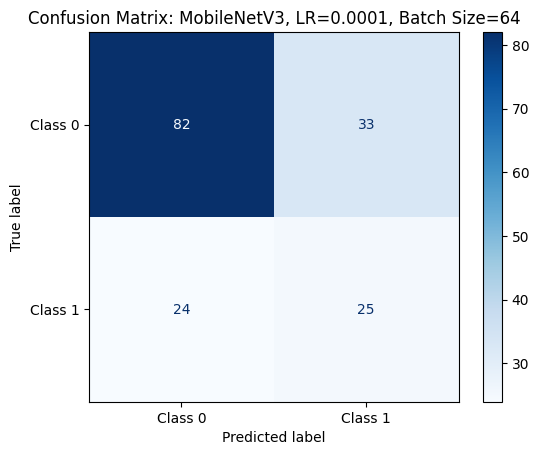

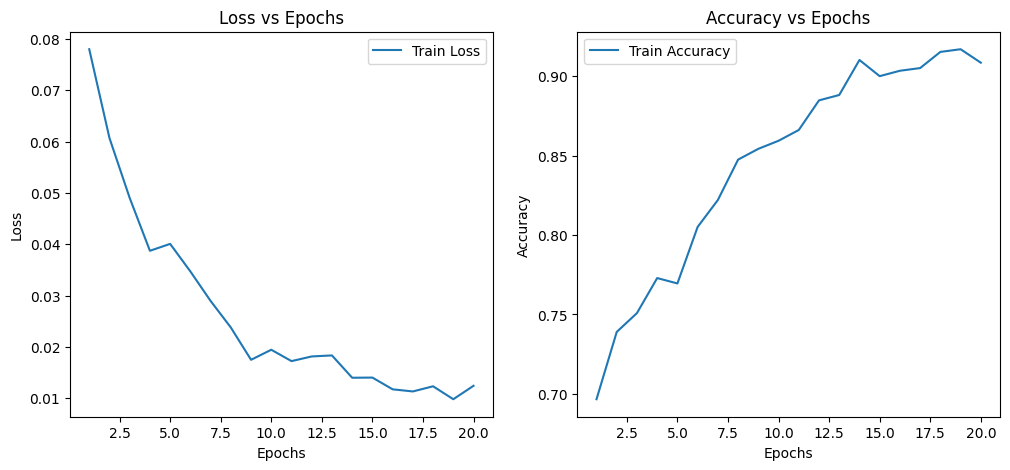


Training EfficientNetB0 with LR=0.0001, Batch Size=64
Epoch 1/20 - Train Loss: 0.0957, Train Acc: 0.5898
Epoch 2/20 - Train Loss: 0.0644, Train Acc: 0.7356
Epoch 3/20 - Train Loss: 0.0555, Train Acc: 0.7424
Epoch 4/20 - Train Loss: 0.0469, Train Acc: 0.7542
Epoch 5/20 - Train Loss: 0.0450, Train Acc: 0.7525
Epoch 6/20 - Train Loss: 0.0393, Train Acc: 0.7780
Epoch 7/20 - Train Loss: 0.0347, Train Acc: 0.7831
Epoch 8/20 - Train Loss: 0.0312, Train Acc: 0.8034
Epoch 9/20 - Train Loss: 0.0296, Train Acc: 0.8169
Epoch 10/20 - Train Loss: 0.0240, Train Acc: 0.8237
Epoch 11/20 - Train Loss: 0.0227, Train Acc: 0.8441
Epoch 12/20 - Train Loss: 0.0207, Train Acc: 0.8576
Epoch 13/20 - Train Loss: 0.0196, Train Acc: 0.8492
Epoch 14/20 - Train Loss: 0.0211, Train Acc: 0.8424
Epoch 15/20 - Train Loss: 0.0170, Train Acc: 0.8847
Epoch 16/20 - Train Loss: 0.0160, Train Acc: 0.8695
Epoch 17/20 - Train Loss: 0.0141, Train Acc: 0.8881
Epoch 18/20 - Train Loss: 0.0191, Train Acc: 0.8644
Epoch 19/20 - Trai

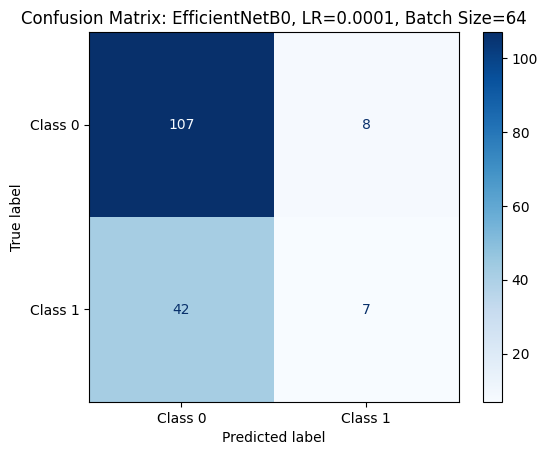

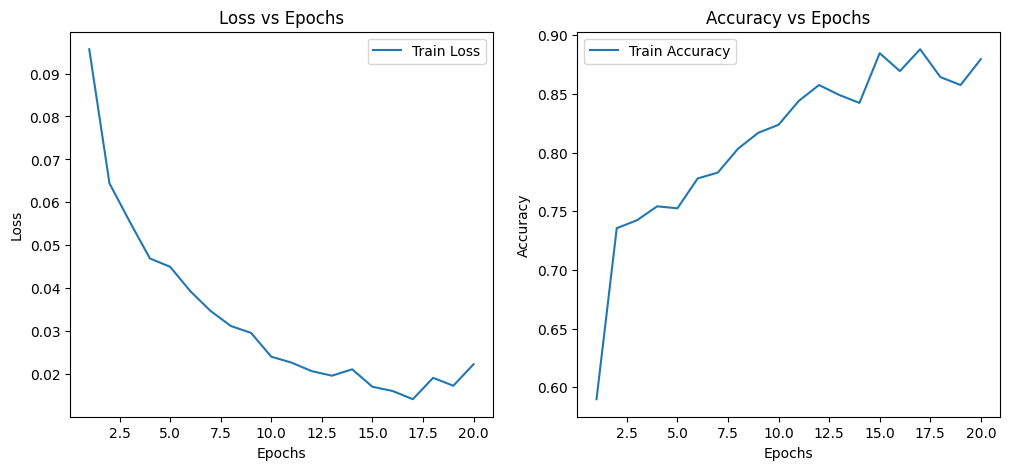


Summary of Cross-Validation Results:
            Model  Learning Rate  Batch Size  Final Train Loss  \
0        ResNet50         0.0001          64          0.001159   
1     MobileNetV3         0.0001          64          0.012448   
2  EfficientNetB0         0.0001          64          0.022262   

   Final Train Accuracy  Validation Loss  Validation Accuracy  Test Accuracy  
0              0.971186         0.050565             0.727273       0.646341  
1              0.908475         0.050977             0.757576       0.652439  
2              0.879661         0.020408             0.772727       0.695122  


In [13]:
def ensure_rgb(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image


train_transform = v2.Compose([
    Lambda(ensure_rgb),
    v2.Resize((256, 256)),  
    v2.RandomCrop((224, 224)), 
    v2.RandomRotation(degrees=10),  
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor(),
])

test_transform = v2.Compose([
    # transforms.Grayscale(),
    # v2.Grayscale(),
    Lambda(ensure_rgb),
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor()
    #
])

CONFIDENCE_THRESHOLD = 0.9  
UNLABELED_LOSS_WEIGHT = 1.0 
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
IMG_SIZE = 224
NUM_CLASSES = 2 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
model.classifier[3] = nn.Linear(in_features=1280, out_features=2)
train_dataset = SmokerDataset(labeled_train, transforms=train_transform)
test_dataset = SmokerDataset(labeled_test, transforms=test_transform)


train_dataset = SmokerDataset(labeled_train, transforms=train_transform)
val_dataset = SmokerDataset(labeled_val, transforms=test_transform)
test_dataset = SmokerDataset(labeled_test, transforms=test_transform)

models_dict = create_models()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss
        
criterion = FocalLoss(alpha=0.6, gamma=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.0001]
batch_sizes = [64]
num_epochs = 20

results = train_and_evaluate_cross_validation(
    models_dict, train_dataset, val_dataset, test_dataset, device, criterion, learning_rates, batch_sizes, num_epochs
)